## このノートブックでは、提出用のシンプルなベースラインを作成し、今後詳しく分析するために重要な特徴量を特定します。

In [1]:
# 必要なライブラリの読み込み
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import seaborn as sns

import gc

import warnings
warnings.filterwarnings("ignore")

In [2]:
# データディレクトリの設定
ROOT_DIR = "../datasets"

In [3]:
# データの読み込み
train_df = pd.read_parquet(f"{ROOT_DIR}/train.parquet")
test_df = pd.read_parquet(f"{ROOT_DIR}/test.parquet")

In [4]:
train_df.shape,  test_df.shape

((363924, 149), (112437, 149))

In [5]:
set(train_df.columns) - set(test_df.columns)

{'money_room'}

In [6]:
set(test_df.columns)- set(train_df.columns) 

{'id'}

 ###  money_roomが目的変数で、'id'列は識別子です。その他の列は両方のデータセットで同じです。

In [7]:
train_money_room = train_df.money_room.values
test_id = test_df['id']

train_df.drop(['money_room'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)


# 基本的なEDA

In [8]:
# 目的変数を見てみましょう

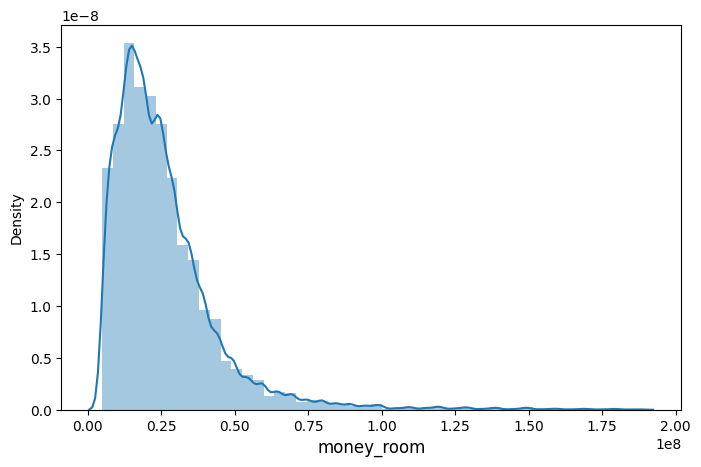

In [9]:
plt.figure(figsize=(8,5))
sns.distplot(train_money_room, bins=50, kde=True)
plt.xlabel('money_room', fontsize=12)
plt.show()

###  データは非常に長い右裾を持っています。これは問題になる可能性があります。money_room変数の対数をプロットしてみましょう。

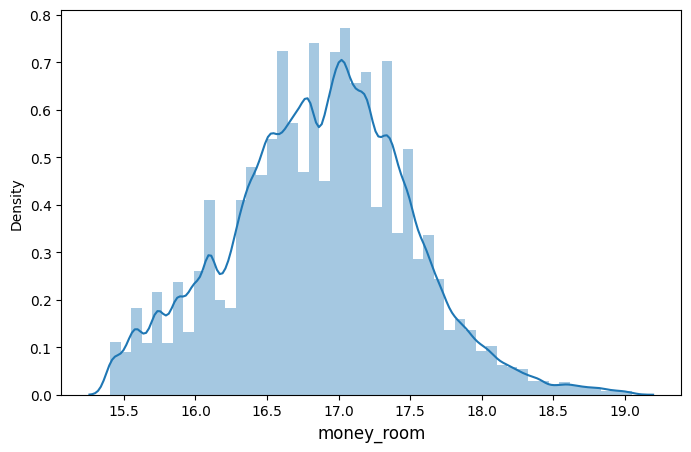

In [10]:
plt.figure(figsize=(8,5))
sns.distplot(np.log1p(train_money_room), bins=50, kde=True)
plt.xlabel('money_room', fontsize=12)
plt.show()

### これは正規分布のように見えます。

README.pdf によると、**学習データとテストデータは掲載時期が異なります**。 

> 学習用データ：2019〜2022年の 1月または 7月  
> テストデータ：2023年の 1月または 7月

これを確認してみましょう。

In [11]:
train_df["target_ym"].max(), test_df["target_ym"].min()

(np.int64(202207), np.int64(202301))

### 学習データとテストデータが異なる時期のものだと確認できました。

## 欠損データ

In [12]:
def get_missing_report(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.loc[missing_df['missing_count']>0]
    missing_df["missing_ratio"] = missing_df["missing_count"]/len(df)
    
    return missing_df

In [13]:
train_missing = get_missing_report(train_df)
test_missing = get_missing_report(test_df)

In [14]:
train_missing

,column_name,missing_count,missing_ratio
6,building_name,164886,0.453078
7,building_name_ruby,363924,1.000000
8,homes_building_name,25994,0.071427
9,homes_building_name_ruby,260019,0.714487
10,unit_count,136003,0.373713
...,...,...,...
143,statuses,12590,0.034595
144,parking_keiyaku,356329,0.979130
145,money_hoshou_company,363924,1.000000
146,free_rent_duration,363924,1.000000


### 欠損値を持つ列が多数あり、中には完全に空のものもあります。今後処理する必要があります。

In [15]:
train_missing[train_missing.missing_ratio==1]

,column_name,missing_count,missing_ratio
7,building_name_ruby,363924,1.0
46,name_ruby,363924,1.0
130,school_ele_code,363924,1.0
133,school_jun_code,363924,1.0
145,money_hoshou_company,363924,1.0
146,free_rent_duration,363924,1.0
147,free_rent_gen_timing,363924,1.0


In [16]:
# remove them from train and test
drop_cols = train_missing[train_missing.missing_ratio==1].column_name
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

# 基本的な前処理

###  'addr1_1'と'addr1_2'を実際の都道府県名と市区町村名に置き換えて、直感的に理解できるようにします

In [17]:
data_definition = pd.ExcelFile(f"{ROOT_DIR}/data_definition.xlsx")

In [18]:
train_df[['addr1_1', 'addr1_2']].sample(3, random_state=2025)

,addr1_1,addr1_2
48171,11,201
16175,27,147
286956,1,106


In [19]:
# data_definition.sheet_names
import polars as pl

codes = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[3])
codes.columns = ['No.', 'addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']
codes = codes[['addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']]

# train_df = pd.merge(train_df, codes, on=['addr1_1', 'addr1_2'], how='inner')
# test_df = pd.merge(test_df, codes, on=['addr1_1', 'addr1_2'], how='inner')
train_df = pl.DataFrame(train_df)
test_df = pl.DataFrame(test_df)
codes = pl.DataFrame(codes)

codes = codes.with_columns(
    pl.col("addr1_2").cast(pl.Int64)
)

In [20]:
train_df = train_df.join(codes, on=['addr1_1', 'addr1_2'], how='inner')
test_df = test_df.join(codes, on=['addr1_1', 'addr1_2'], how='inner')
del codes

In [21]:
train_df[['Prefecture name', 'City/town/village name']].sample(3, seed=2025)

Prefecture name,City/town/village name
str,str
"""静岡県""","""浜松市南区"""
"""京都府""","""京都市右京区"""
"""埼玉県""","""入間市"""


## 特徴量抽出
data_definition.xlsx を確認すると、以下のカラムにはスラッシュ区切りで複数の値が格納されており、展開が必要です：
"building_tag_id", "unit_tag_id",
"reform_interior", "reform_exterior", "reform_wet_area",
"statuses"


In [22]:
train_df["building_tag_id"].sample(3)

building_tag_id
str
"""321101/210201/320201/210301/31…"
"""321001/210301/210299/320901/21…"
"""210201/210101/210301"""


### これらの列を展開し、それに基づいて新たな特徴量を作成します。また、可読性を高めるために、タグIDを対応するタグ内容に置き換えます。

In [23]:
tag_master = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[2])
tag_master = tag_master[['タグID', 'タグ内容']]
tag_master["タグID"] = tag_master["タグID"].astype("str")
tag_master.set_index('タグID', inplace=True)
tag_master = tag_master.to_dict()['タグ内容']

タグIDから内容へのマッピング辞書を作成しました。次のようになります
```
{'210101': '公営水道',
 '210102': '井戸',
 ...
 '210199': '水道その他'}
```

## スラッシュ区切りの列を展開

In [24]:
slashed_columns = ["building_tag_id", "unit_tag_id", 
                   "reform_interior",  "reform_exterior","reform_wet_area",
                  "statuses"]

In [25]:
import polars as pl

# slashed_columns: スラッシュ区切りの列名リスト
# tag_master: {タグID: タグ名} の dict を想定

def get_slashed_tags(df: pl.DataFrame) -> pl.DataFrame:
    """スラッシュ区切りの値を持つ列を個別の列に変換する（Polars版）"""

    # 行を識別するためのIDを付与
    df_idx = df.with_row_index("row_id")

    temp_dfs: list[pl.DataFrame] = []

    for i, col in enumerate(slashed_columns):
        # "a/b/c" → ["a", "b", "c"] に分割して縦持ちに
        tags = (
            df_idx
            .select(
                "row_id",
                pl.col(col).str.split("/").alias("tag")
            )
            .explode("tag")  # 1行複数タグ → 1タグ1行
        )

        # tag 列をダミー変数に変換（row_id はそのまま残る）
        dummies = tags.to_dummies(columns="tag")

        # 同じ row_id で複数行になっているので、0/1 の max でまとめる
        col_df = (
            dummies
            .group_by("row_id")
            .max()
        )

        # row_id 以外がダミー列
        dummy_cols = [c for c in col_df.columns if c != "row_id"]

        # まず 0/1 を文字列に変換（pandas の .astype("str") 相当）
        # col_df = col_df.with_columns(
        #     [pl.col(c).cast(pl.Utf8) for c in dummy_cols]
        # )

        # カラム名 "tag_123" → "元の列名 タグ名" に変換
        rename_map: dict[str, str] = {}
        for old in dummy_cols:
            # to_dummies の列名は "tag_<ID>" になっている想定
            tag_id = old.split("_", 1)[1] if "_" in old else old
            tag_name = tag_master.get(tag_id, tag_id)
            new_name = f"{col} {tag_name}"
            rename_map[old] = new_name

        col_df = col_df.rename(rename_map)

        # 2列目以降は row_id が重複するので削る
        if i > 0:
            col_df = col_df.drop("row_id")

        temp_dfs.append(col_df)

    # 列方向に結合
    result = pl.concat(temp_dfs, how="horizontal")

    # row_id は不要なので削除（行順は row_id 順のまま）
    result = result.sort("row_id").drop("row_id")

    return result


### train_dfとtest_dfで個別に実行できますが、`pandas get_dummies` を使用しているため、testとtrainのデータフレームで列数が一致しない可能性があります。そこで、結合 -> 列を展開 -> 再度分割します。

## スラッシュ区切りの列を取得
この処理には約**1分ほど**かかります。

In [26]:
combined_df = pl.concat([train_df, test_df], how="vertical_relaxed")
slashed_df = get_slashed_tags(combined_df)

In [27]:
slashed_df.head()

building_tag_id 楽器相談,building_tag_id 楽器不可,building_tag_id セキュリティ会社加入済み,building_tag_id 公営水道,building_tag_id 井戸,building_tag_id 水道その他,building_tag_id 都市ガス,building_tag_id プロパンガス,building_tag_id ガスその他,building_tag_id 下水,building_tag_id 浄化槽,building_tag_id 汲取,building_tag_id 排水その他,building_tag_id オール電化,building_tag_id 太陽光発電システム,building_tag_id 295101,building_tag_id 295401,building_tag_id 295501,building_tag_id オートロック,building_tag_id 防犯カメラ,building_tag_id 管理人常駐,building_tag_id 24時間有人管理,building_tag_id セキュリティ充実,building_tag_id エレベーター,building_tag_id ごみ出し24時間OK,building_tag_id ペット用施設,building_tag_id フロントサービス,building_tag_id キッズルーム,building_tag_id 駐車場あり,building_tag_id バイク置き場あり,building_tag_id 駐輪場あり,building_tag_id 宅配ボックス,building_tag_id コンシェルジュサービス,building_tag_id 323301,building_tag_id 323401,building_tag_id 323601,building_tag_id デザイナーズ,…,statuses キッズルーム,statuses バイク置き場あり,statuses 駐輪場あり,statuses 宅配ボックス,statuses デザイナーズ,statuses タイル貼り,statuses 外断熱,statuses 保証付住宅,statuses 住宅性能保証制度証明書,statuses 分譲賃貸,statuses 免震構造,statuses 耐震構造,statuses 制震構造,statuses 設計住宅性能評価書,statuses フラット35・S適合証明書,statuses 長期優良住宅認定通知書,statuses 耐震基準適合証明書,statuses 建設住宅性能評価書（新築時）,statuses 建設住宅性能評価書（既存住宅）,statuses 建築確認完了検査済証,statuses 法適合状況調査報告書,statuses 低炭素住宅,statuses 瑕疵保険（国交省指定）による保証利用可,statuses 瑕疵保険（国交省指定）による保証付,statuses 瑕疵保証（不動産会社独自）付,statuses インスペクション（建物検査）報告書,statuses 新築時・増改築時の設計図書,statuses 修繕・点検の記録,statuses 336401,statuses BELS/省エネ基準適合認定建築物,statuses 1階の物件,statuses 2階以上,statuses 最上階,statuses 角地,statuses 角部屋,statuses 350201,statuses null
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,…,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### 374列を追加作成しました。これらを結合データフレームに追加し、元の列を削除します。

In [28]:
# 新しく生成された列名を保存
tag_columns = slashed_df.columns
# 抽出した特徴量を結合
combined_df = pl.concat([combined_df, slashed_df], how="horizontal")
# スラッシュ区切りの列を削除
combined_df = combined_df.drop(slashed_columns)
# trainとtestに分割
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

In [29]:
del slashed_df
gc.collect()

1037

In [30]:
train_df.shape, test_df.shape

((363924, 520), (112437, 520))

## 築年を処理し、年のみを保持

In [31]:
def parse_year(date_input):
    try:
        date_input = str(date_input)
        return date_input[:4]           
    except Exception as e:
        return str(date_input)

In [32]:
train_df["year_built"].sample(3)

year_built
f64
200710.0
200507.0
197307.0


In [33]:
train_df = train_df.with_columns(
    pl.col("year_built").map_elements(parse_year)
)

test_df = test_df.with_columns(
    pl.col("year_built").map_elements(parse_year)
)


In [34]:
train_df["year_built"].sample(3)

year_built
str
"""1979"""
"""1993"""
"""1997"""


In [35]:
numerical_columns = [
    "unit_count",
    "lon",
    "lat",
    "total_floor_area",
    "building_area",
    "floor_count",
    "basement_floor_count",
    "building_land_area",
    "land_area_all",
    "unit_area_min",
    "unit_area_max",
    "land_setback",
    "land_kenpei",
    "land_youseki",
    "room_floor",
    "balcony_area",
    "room_count",
    "unit_area",
    "empty_number",
    "nl",
    "el",
    "bus_time1",
    "walk_distance1",
    "bus_time2",
    "walk_distance2",
    "traffic_car",
    "snapshot_land_area",
    "snapshot_land_shidou",
    "land_shidou_a",
    "land_shidou_b",
    "land_mochibun_a",
    "land_mochibun_b",
    "house_area",
    "room_kaisuu",
    "madori_number_all",
    "money_kyoueki",
    "money_rimawari_now",
    "money_shuuzen",
    "money_shuuzenkikin",
    "money_sonota1",
    "money_sonota2",
    "money_sonota3",
    "parking_money",
    "parking_distance",
    "parking_number",
    "school_ele_distance",
    "school_jun_distance",
    "convenience_distance",
    "super_distance",
    "hospital_distance",
    "park_distance",
    "drugstore_distance",
    "bank_distance",
    "shopping_street_distance",
    "est_other_distance",
]


### カテゴリカル列の中には、int, float, stringなど混在したデータ型があります. 簡潔にするために、すべて文字列に変換します

In [36]:
categorical_cols = [c for c in train_df.columns if c not in numerical_columns]

In [37]:
cat_col_fix = list(set(categorical_cols) - set(tag_columns))

In [38]:
def convert_cat(cat_val):
    try:
        return str(int(eval(cat_val)))
    except:
        try:
            return str(int(cat_val))
        except:
            return str(cat_val)

In [39]:
train_df = train_df.to_pandas()
test_df = test_df.to_pandas()

train_df[cat_col_fix] = train_df[cat_col_fix].applymap(convert_cat)
test_df[cat_col_fix] = test_df[cat_col_fix].applymap(convert_cat)


In [40]:
len(categorical_cols)

465

## シンプルなモデルの構築  

In [41]:
train_y = np.log1p(train_money_room)

In [ ]:
params = {
    "loss_function" : "MAE",
    # "task_type":  "GPU",  # CPUで実行する場合はこれを削除
    "random_seed": 2025,
    "verbose": 1000,
    "iterations": 1
}

In [43]:
train_df = train_df.fillna(np.nan)
test_df = test_df.fillna(np.nan)

In [44]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(**params) 
model.fit(train_df, train_y, cat_features=categorical_cols)

0:	learn: 0.4886150	total: 1.68s	remaining: 0us


In [56]:
# 保存
import pickle
with open("../models/catboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
# # 読み込み用
# with open("../models/catboost_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)

# # 推論例
# pred = loaded_model.predict(test_df)
# print(pred[:10])

[16.88302386 16.90028201 16.88814303 16.89601399 16.88302386 16.90129069
 16.88302386 16.89601399 16.90129069 16.89601399]


In [57]:
train_pred = np.expm1(model.predict(train_df))

In [46]:
from sklearn.metrics import mean_absolute_percentage_error
mape_error = mean_absolute_percentage_error(train_money_room, train_pred)
print("MAPE Error ", mape_error)

MAPE Error  0.5678790285270185


In [47]:
feature_importance = pd.DataFrame({'feature_name': train_df.columns,
                            'importance': model.get_feature_importance()})

In [48]:
feature_importance = feature_importance[feature_importance["importance"]>0]

In [49]:
#  今後の分析のために保存します。
feature_importance.to_csv("feature_importance.csv", index=False)

In [50]:
feature_importance.sort_values("importance", ascending=False)[:20]

,feature_name,importance
18,year_built,30.064671
100,madori_kind_all,26.369284
136,City/town/village name,20.825550
94,house_area,14.297417
3,building_create_date,8.443078


# 提出用ファイルを作成する

In [51]:
test_pred = model.predict(test_df)
test_pred = np.expm1(test_pred)

In [52]:
submit_df = pd.DataFrame({"id": test_id, "money_room":test_pred})

In [53]:
submit_df.head(2)

,id,money_room
0,0,2.148840e+07
1,1,2.186247e+07


In [54]:
submit_df.to_csv("sample_submit.csv", index=False, header=False)